# Thanks Recipient Experiment Power Analysis
[J. Nathan Matias](https://github.com/natematias)
June 2019

Some components of this are drawn from [github.com/natematias/poweranalysis-onlinebehavior](https://github.com/natematias/poweranalysis-onlinebehavior).

Eventually, this power analysis code will ask a series of questions of [historical data prepared by Max Klein](https://docs.google.com/document/d/1RKJZqoWKQuWDoKk94drIEsJWK6kBUeZ8KIJOyEqDTTE/edit) and produce a series of answers used for power analysis and study design in CivilServant's research with Wikipedians on [the effects of giving thanks to other Wikipedians](https://meta.wikimedia.org/wiki/Research:Testing_capacity_of_expressions_of_gratitude_to_enhance_experience_and_motivation_of_editors):
* The experiment plan is on Overleaf: [Experiment Plan: Mentoring and Protection in Wikipedia Moderation](https://www.overleaf.com/project/5c379e06f882d02f5b8c9f44)

This analysis will define and report the following:

* Assumptions about minimum observable treatment effects for each DV
* Reports on the statistical power, bias, and type S error rate for all possible estimators, given the above assumptions
* Data-driven decisions:
    * Decisions about the final set of measures to use
    * Decisions about the randomization procedure
    * Decisions about the final estimators to use
    * Decisions about the sample size to specify for the experiment
    * Decisions about any stop rules to use in the experiment

**Note:** Since the thanks recipient study will involve participants on multiple language Wikipedias, this code defines a procedure that can be reproduced for the following language wikipedias:
* German
* Persian
* Arabic
* Plish

# Load Libraries

In [1]:
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(gmodels)
library(tidyverse)
library(viridis)
library(fabricatr)
library(estimatr)
library(DeclareDesign)
library(blockTools)
library(beepr)
## Installed DeclareDesign 0.13 using the following command:
# install.packages("DeclareDesign", dependencies = TRUE,
#                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

library(survminer)
library(survival)
## ^^ documentation: https://cran.r-project.org/web/packages/survminer/vignettes/Informative_Survival_Plots.html

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::inv

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] survival_2.43-3      survminer_0.4.3      ggpubr_0.2          
 [4] magrittr_1.5         beepr_1.3            blockTools_0.6-3    
 [7] DeclareDesign_0.12.0 randomizr_0.16.1     estimatr_0.14       
[10] fabricatr_0.6.0      viridis_0.5.1        viridisLite_0.3.0   
[13] forcats_0.3.0        str

# Load Power Analysis Dataframes and Review The Data

In [11]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"
de.power.df <- read.csv(file.path(data.path, "de_gratitude_power-analysis_dataset_sim_date_20180306_with_email.csv"))
fa.ar.pl.power.df <- read.csv(file.path(data.path, "gratitude_power-analysis_dataset_sim_date_20180306_with_email.csv"))
fa.power.df <- subset(fa.ar.pl.power.df, lang=="fa")
ar.power.df <- subset(fa.ar.pl.power.df, lang=="ar")
pl.power.df <- subset(subset(fa.ar.pl.power.df, lang=="pl"))
simulated.treatment.date <- as.Date("2018-03-06")

In [12]:
#colnames(pl.power.df)

### Load Power Analysis Utilities

In [13]:
source("../power-analysis-utilities.R")

## Issues with the dataset
This is a list of discrepancies between the specification and the data file, Feb 2019
* `num_prev_thanks_before_treatment` should be called `num_prev_thanks_pre_treatment`, as specified in the "data needed" file
* `newcomer` should be defined in the CSV
* `labor` should be spelled consistently

## Review Blocking & Assignment Variables

Notice that active Wikipedia editors who have been around for longer and who are part of this sample tend to write more edits and put in more labor hours on average. This is a *very* good reason to block on those characteristics.

In [14]:
# print("email newcomer")
# print(aggregate(de.power.df[c("num_edits_90_post_treatment")],
#               FUN=mean, by = list(de.power.df$has_email, de.power.df$newcomer)))
# print("")
# print("email newcomer")
# print(aggregate(de.power.df[c("labour_hours_90_post_treatment")],
#               FUN=mean, by = list(de.power.df$has_email, de.power.df$newcomer)))


In [19]:
subset.and.review.variables <- function(df.to.review, remove.outliers=TRUE){
    print(      "========================")
    print(paste("Review Variables For:", unique(df.to.review$lang)))
    print(      "========================")
    cat("\n")
    
    print(paste("Total rows:", nrow(df.to.review)))
    cat("\n")

    # VARIABLE: experience_level_pre_treatment: Definition: 
    #  the elapsed number of days between registration 
    #  and last edit in the observation period up to the simulated treatment date

    df.to.review$prev_experience <- as.integer(gsub("bin_", "", df.to.review$experience_level_pre_treatment))
    df.to.review$prev_experience <- factor(df.to.review$prev_experience, 
                                          levels = sort(unique(df.to.review$prev_experience)))
    
    df.to.review$num_prev_thanks_pre_treatment <- df.to.review$num_prev_thanks_before_treatment
            
    ## SHOW NUM EDITS BY EXPERIENCE GROUP:
    print("Aggregate num_edits_90_pre_treatment")
    print(aggregate(df.to.review[c("num_edits_90_pre_treatment")]>0,
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    ## SHOW LABOR HOURS BY EXPERIENCE GROUP:
    print("Aggregate labor_hours_90_pre_treatment")
    print(aggregate(df.to.review[c("labour_hours_90_pre_treatment")],
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    ## BECAUSE THIS DATASET INCLUDES INACTIVE EDITORS
    ## WE REDUCE THE DATASET ONLY TO EDITORS ACTIVE IN THE LAST 90 DAYS
    print(paste("Number of rows before removing inactive users:", nrow(df.to.review)))
    df.to.review <- subset(df.to.review, num_edits_90_pre_treatment > 0 )
    print(paste("Number of rows after removing inactive users:", nrow(df.to.review)))
    cat("\n")
    if("num_goodfaith_pre_treatment" %in% colnames(df.to.review)){
        df.to.review <- subset(df.to.review, num_goodfaith_pre_treatment>=4)
    }else{
        df.to.review <- subset(df.to.review, num_flagged_revisions_pre_treatment>=4)
        
    }
    print(paste("Number of rows after removing users without enough goodfaith edits:", nrow(df.to.review)))
    cat("\n")
    
    ## subset all observations less than or equal to the 99% confidence intervals
    if(remove.outliers){
        mean.lh <- mean(df.to.review$labour_hours_90_pre_treatment)
        sd.lh   <- sd(df.to.review$labour_hours_90_pre_treatment)
        df.to.review <- subset(df.to.review, labour_hours_90_pre_treatment <= mean.lh + 2.58 * sd.lh)
     }
    print(paste("Number of rows after removing outliers on labor hours:", nrow(df.to.review)))
    cat("\n")

    print("prev_experience")
    print(summary(factor(df.to.review$prev_experience)))
    cat("\n")

    # VARIABLE: newcomer: accounts that were created within in the last 90 days, 
    #   and which have made at least 3 edits since starting their account
    df.to.review$newcomer <- df.to.review$experience_level_pre_treatment == "bin_0" & 
        df.to.review$num_edits_90_pre_treatment >= 4

    
    print("BLOCKING VARIABLES")
    print("--------------------")
    
    
    print("Number of Newcomers with 3 or more edits")
    print(summary(subset(df.to.review, experience_level_pre_treatment == "bin_0")$newcomer))
    cat("\n")

    print("NEWCOMERS AND EMAILS")
    print("--------------------")
    print(CrossTable(df.to.review$has_email, df.to.review$newcomer, 
           prop.r = FALSE, prop.c=TRUE, prop.t = FALSE, prop.chisq = FALSE))
    
    df.to.review$has_email <- df.to.review$has_email == "True"
    
    
    # VARIABLE: num_prev_thanks_pre_treatment
    print("num_prev_thanks_pre_treatment")
    print(summary(df.to.review$num_prev_thanks_pre_treatment))
    cat("\n")
    
    ## SHOW PREVIOUS THANKS BY EXPERIENCE GROUP:
    print("num_prev_thanks_pre_treatment by prev_experience")
    print(aggregate(df.to.review[c("num_prev_thanks_pre_treatment")],
          FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    # new section: behavioral variables
    print("BEHAVIORAL VARIABLES")
    print("--------------------")
    cat("\n")

    # VARIABLE: num.edit.diff: the number of edits
    # in the 90 days after treatment minutes the number in the 90 before treatment
    df.to.review$num.edit.diff <- df.to.review$num_edits_90_post_treatment - 
        df.to.review$num_edits_90_pre_treatment

    # VARIABLE: num.edit.diff: the number of edits
    # in the 90 days after treatment minutes the number in the 90 before treatment
    df.to.review$labor.hour.diff <- df.to.review$labour_hours_90_post_treatment - 
        df.to.review$labour_hours_90_pre_treatment
    
    ## SHOW NUM EDIT DIFF BY EXPERIENCE GROUP:
    print("Show pre/post difference in 90 day num edits by experience group")
    print(aggregate(df.to.review[c("num.edit.diff")],
          FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    
    ## ASSIGN ACCOUNT AGE AND LABOR HOUR PER DAY DIFFERENCE
    df.to.review$account.age.days <- as.integer(simulated.treatment.date - as.Date(df.to.review$user_registration))

    df.to.review$labor_hours_per_day_90_pre_treatment <- df.to.review$labour_hours_90_pre_treatment / 90
    df.to.review[df.to.review$prev_experience==0]$labor_hours_per_day_90_pre_treatment <- df.to.review[df.to.review$prev_experience==0]$labour_hours_90_pre_treatment / df.to.review$account.age.days
    
    df.to.review$labor_hours_per_day_90_post_treatment <- df.to.review$labour_hours_90_post_treatment / 90
    df.to.review$labor.hour.per.day.diff <- df.to.review$labor_hours_per_day_90_post_treatment - df.to.review$labor_hours_per_day_90_pre_treatment

    
    ## SHOW LABOR HOUR DIFF BY EXPERIENCE GROUP:
    print("Show pre/post difference in 90 day labor hours by experience group")
    print(aggregate(df.to.review[c("labor.hour.diff")],
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    print(ggplot(df.to.review, aes(prev_experience, labor.hour.diff, color=prev_experience)) +
        geom_boxplot() +
        theme_bw() +
        ggtitle(paste("Difference in 90 day Pre/PostLabor Hours by Experience:", unique(df.to.review$lang), "dataset"))
    )
    
    
    ## SHOW LABOR HOUR DIFF PER DAY BY EXPERIENCE GROUP:
    print("Show pre/post difference in 90 day labor hours per day by experience group")
    print(aggregate(df.to.review[c("labor.hour.per.day.diff")],
              FUN=mean, by = list(df.to.review$prev_experience)))
    cat("\n")

    print(ggplot(df.to.review, aes(prev_experience, labor.hour.per.day.diff, color=prev_experience)) +
        geom_boxplot() +
        theme_bw() +
        ggtitle(paste("Difference in 90 day Pre/PostLabor Hours per day by Experience:", unique(df.to.review$lang), "dataset"))
    )

    
    
    df.to.review    
}

## Review Variables, German Wikipedia

[1] "========================"
[1] "Review Variables For: de"
[1] "========================"

[1] "Total rows: 1800"

[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                        0.5
2      90                        0.5
3     180                        0.5
4     365                        0.5
5     730                        0.5
6    1460                        0.5
7    2920                        0.5

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         1.042
2      90                         2.800
3     180                         3.368
4     365                         3.979
5     730                         9.276
6    1460                         8.429
7    2920                        11.994

[1] "Number of rows before removing inactive users: 1800"
[1] "Number of rows after removing inactive users: 900"

[1] "Number of rows after removing users without enough goodf

Warning message in `[<-.data.frame`(`*tmp*`, df.to.review$prev_experience == 0, :
“provided 46 variables to replace 45 variables”

[1] "Show pre/post difference in 90 day labor hours by experience group"
  Group.1 labor.hour.diff
1       0         -4.0332
2      90         -6.2234
3     180         -2.1442
4     365         -1.1138
5     730         -0.9547
6    1460         -1.3996
7    2920         -1.8343

[1] "Show pre/post difference in 90 day labor hours per day by experience group"
  Group.1 labor.hour.per.day.diff
1       0                -0.04481
2      90                -0.06915
3     180                -0.02382
4     365                -0.01238
5     730                -0.01061
6    1460                -0.01555
7    2920                -0.02038



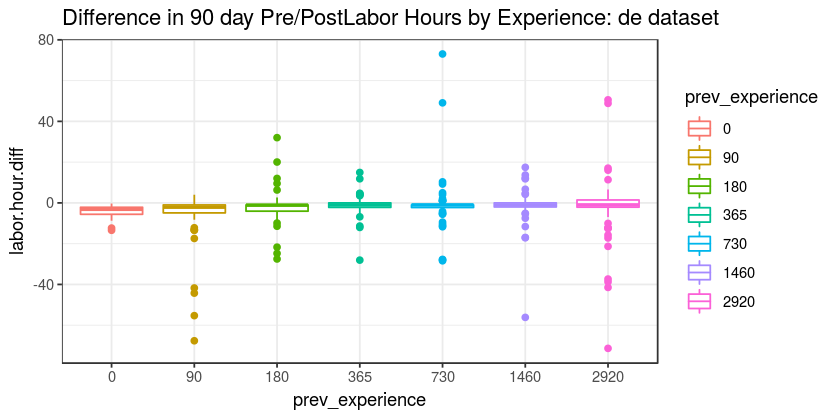

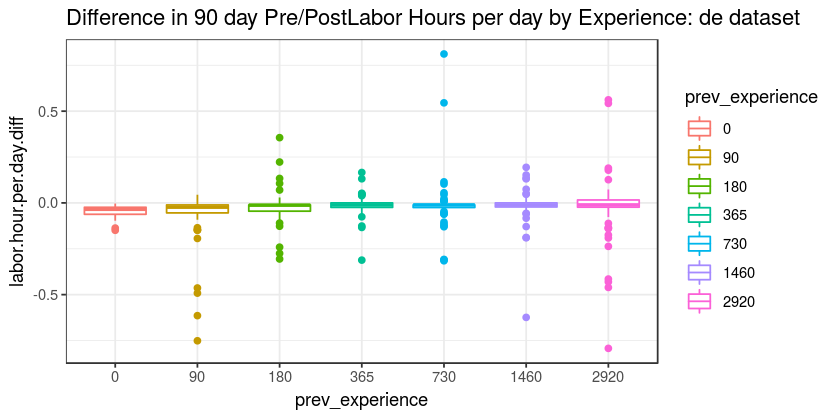

In [20]:
de.power.sub.df <- subset.and.review.variables(de.power.df)

## Review Variables, Persian Wikipedia

[1] "========================"
[1] "Review Variables For: fa"
[1] "========================"

[1] "Total rows: 2844"

[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                     0.9009
2      90                     0.5000
3     180                     0.5000
4     365                     0.5000
5     730                     0.5000
6    1460                     0.5000
7    2920                     0.5000

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         2.043
2      90                         3.998
3     180                         2.890
4     365                         3.819
5     730                         7.127
6    1460                         9.300
7    2920                        15.844

[1] "Number of rows before removing inactive users: 2844"
[1] "Number of rows after removing inactive users: 1600"

[1] "Number of rows after removing users without enough good

Warning message in `[<-.data.frame`(`*tmp*`, df.to.review$prev_experience == 0, :
“provided 58 variables to replace 57 variables”

[1] "Show pre/post difference in 90 day labor hours by experience group"
  Group.1 labor.hour.diff
1       0         -4.0928
2      90         -8.1224
3     180         -2.8168
4     365         -1.9519
5     730         -0.3882
6    1460         -1.2591
7    2920         -2.2891

[1] "Show pre/post difference in 90 day labor hours per day by experience group"
  Group.1 labor.hour.per.day.diff
1       0               -0.045476
2      90               -0.090249
3     180               -0.031298
4     365               -0.021688
5     730               -0.004313
6    1460               -0.013990
7    2920               -0.025434



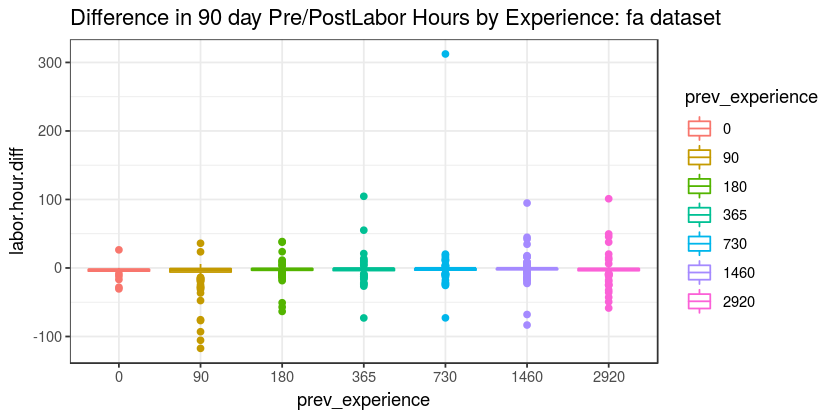

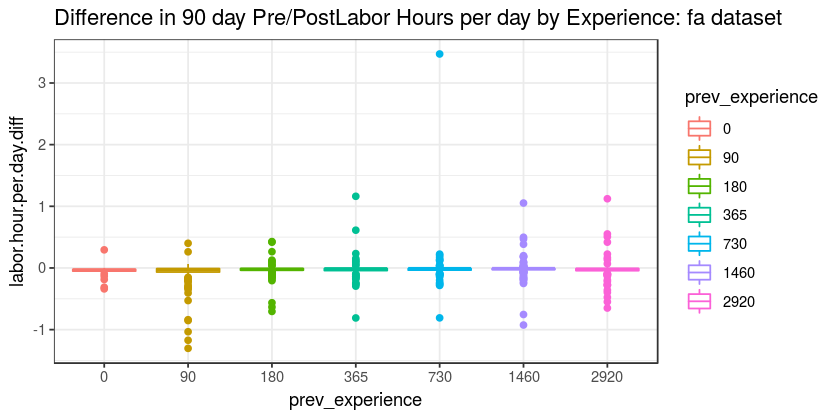

In [21]:
fa.power.sub.df <- subset.and.review.variables(fa.power.df)

## Review Variables, Arabic Wikipedia

In [22]:
ar.power.sub.df <- subset.and.review.variables(ar.power.df)

[1] "========================"
[1] "Review Variables For: ar"
[1] "========================"

[1] "Total rows: 2875"

[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                     0.8421
2      90                     0.5000
3     180                     0.5000
4     365                     0.5000
5     730                     0.5000
6    1460                     0.5000
7    2920                     0.5000

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         1.541
2      90                         5.155
3     180                         6.530
4     365                         3.922
5     730                         6.778
6    1460                        10.074
7    2920                        17.173

[1] "Number of rows before removing inactive users: 2875"
[1] "Number of rows after removing inactive users: 1600"

[1] "Number of rows after removing users without enough good

ERROR: Error in `[.data.frame`(df.to.review, df.to.review$prev_experience == : undefined columns selected


## Review Variables, Polish Wikipedia

[1] "========================"
[1] "Review Variables For: pl"
[1] "========================"

[1] "Total rows: 2868"

[1] "Aggregate num_edits_90_pre_treatment"
  Group.1 num_edits_90_pre_treatment
1       0                     0.8547
2      90                     0.5000
3     180                     0.5000
4     365                     0.5000
5     730                     0.5000
6    1460                     0.5000
7    2920                     0.5000

[1] "Aggregate labor_hours_90_pre_treatment"
  Group.1 labour_hours_90_pre_treatment
1       0                         2.025
2      90                         2.724
3     180                         5.461
4     365                        12.156
5     730                         9.775
6    1460                         9.531
7    2920                        11.038

[1] "Number of rows before removing inactive users: 2868"
[1] "Number of rows after removing inactive users: 1600"

[1] "Number of rows after removing users without enough good

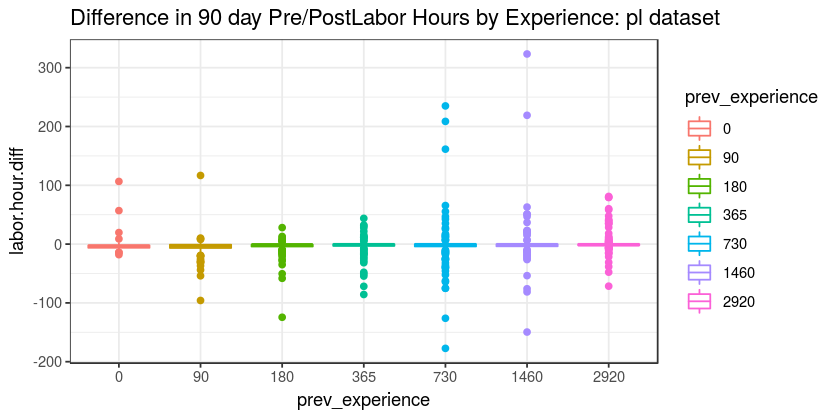

In [207]:
pl.power.sub.df <- subset.and.review.variables(pl.power.df)

# Load and Plot Survival Tables
This table reports the number of active users by week N for the first four weeks, per language. Tables are generated by [survival-analysis-of-power-analysis-dataset-R.ipynb](survival-analysis-of-power-analysis-dataset-R.ipynb)

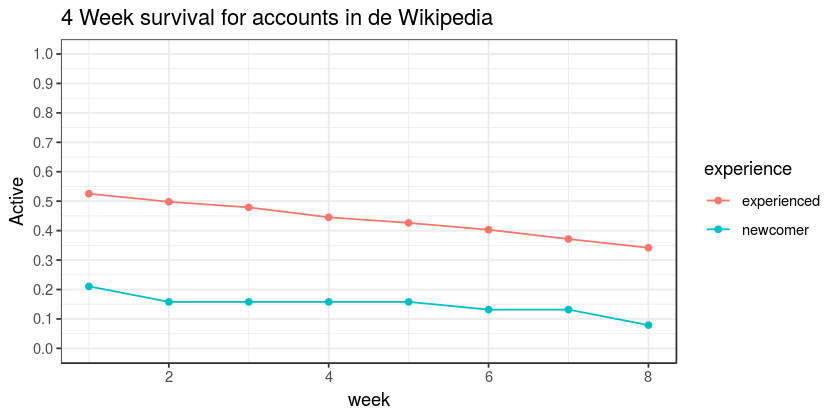

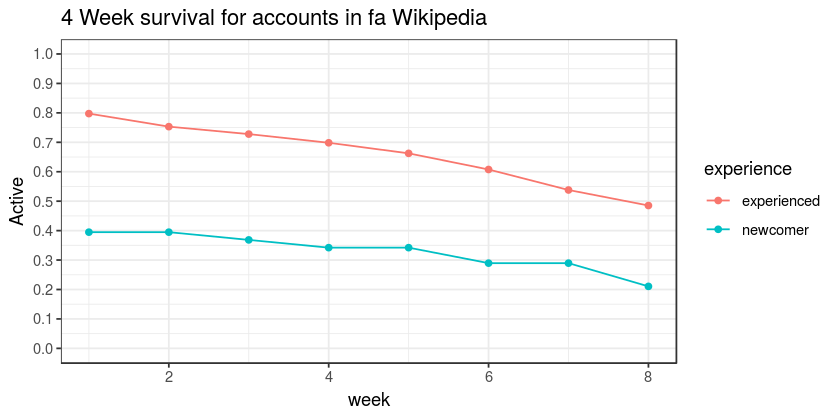

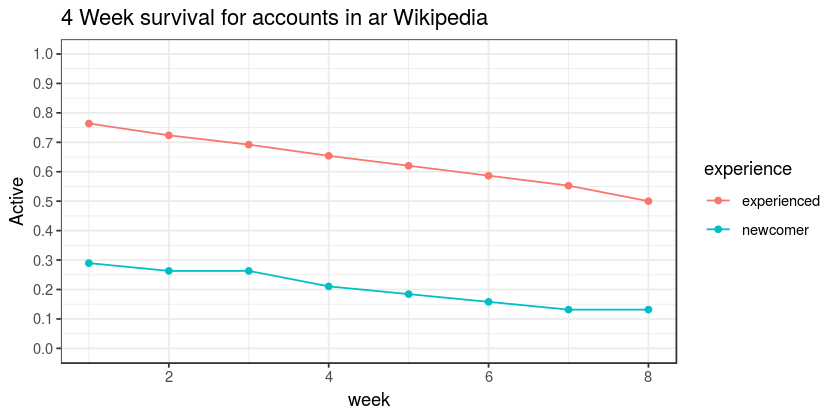

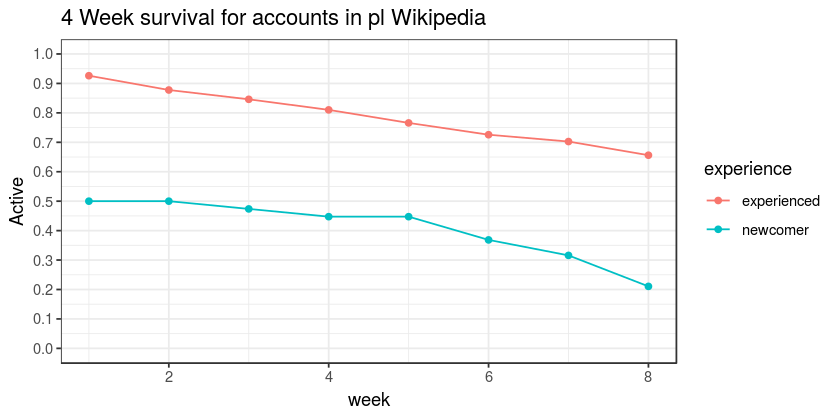

In [209]:
survival.tables <- read.csv("fa.ar.pl.de.20180306.survival.tables.csv")
for(language in unique(survival.tables$lang)){
    survival.table <- subset(survival.tables, lang==language)
    p <- ggplot(survival.table, (aes(week, active, color=experience))) +
         geom_line() +
         geom_point() + 
         scale_y_continuous(name="Active", breaks=seq(0,1,0.1), limits=c(0,1)) +
         theme_bw() + 
         ggtitle(paste("4 Week survival for accounts in", language, "Wikipedia"))
    print(p)
}

# Load Retention Data & Estimate Language-Specific Retention Rates

In [210]:
account.period.df <- read.csv("fa.ar.pl.de.20180306.account.periods.csv")

In [211]:
mean(subset(account.period.df, lang=="de" & week==4 & prev_experience == 0 )$inactive)
mean(subset(account.period.df, lang=="de" & week==4 & prev_experience > 0 )$inactive)

[1] 0.8421

[1] 0.5549

In [212]:
colnames(account.period.df)

[1] "X"                             "user_id"                      
 [3] "user_registration"             "lang"                         
 [5] "prev_experience"               "active_in_30_pre_treatment"   
 [7] "num_prev_thanks_pre_treatment" "num_edits_90_pre_treatment"   
 [9] "labour_hours_90_pre_treatment" "week"                         
[11] "num_edits"                     "any_edits"                    
[13] "labor_hours"                   "inactive"

In [213]:
apply.experience.labor.hours <- function(ref.power.df, config.df){
    for(experience.level in sort(unique(ref.power.df$prev_experience))){
        config.df[paste("exp.",experience.level,".labor.hour.90.day.before.mean", sep="")] <- mean(
            subset(ref.power.df, prev_experience == experience.level)$labour_hours_90_pre_treatment)
        config.df[paste("exp.",experience.level,".labor.hour.90.day.before.sd", sep="")] <- sd(
            subset(ref.power.df, prev_experience == experience.level)$labour_hours_90_pre_treatment)
    }
    config.df
}

In [214]:
pa.config.newcomer <- data.frame(
    n.max    = 2000, # max number of observations
    n.min    = 800, # min number of observations
    
    survey.week.interval = 2, 
    # simulated survey completion rate of all those
    # who were active on Wikipedia at that time, among the enrolled participants
    survey.participation.rate = 0.2, # 20%, via Julia
        
    # QUESTION: DO WE EXPECT THE EFFECT TO BE MULTIPLICATIVE OF THE LABOR HOURS
    #           OR THE SAME AMOUNT, NO MATTER HOW MANY LABOR HOURS A PERSON TYPICALLY PUTS IN?
    # ANSWER:   LET'S LOOK FOR A MINIMUM ADDITIVE LABOR HOURS, SINCE THERE IS A MINIMUM OBSERVABLE
    #           AMOUNT BASED ON THE WAY THE MEASURE IS CONSTRUCTED

    # the minimum effect we want to be able to observe for any group:
    # a thirty minute increase in the number of labor hours over 90 days
    # assumption, the treatment group has the same standard deviation
    labor.hour.diff.90.day.treat.mean.effect = 0.25,
    labor.hour.diff.90.day.treat.sd.effect = 0.5,
    
    ## EFFECT ON NUMBER OF THANKS GIVEN
    ## we are going to estimate the average treatment effect
    ## since negbin and logistic will be difficult to estimate
    thanks.given.90.day.placebo.value = 0,
    thanks.given.90.day.treat.theta = 0.2,
    thanks.given.90.day.treat.mu = 0.1,
    thanks.given.90.day.estimand = mean(rnbinom(10000, 0.2, mu = 0.1)),
    
    
    ## EFFECT ON INACTIVITY
    ## This is the probability of continuing to be an editor of Wikipedia 
    ## after 4 weeks, where inactivity is defined as whether the account
    ## had made any edits in the three week period following the 4th week
    ## as defined in survival-analysis-of-power-analysis-dataset-R
    inactive.control.mean = NA,
    # we want to be able to observe at least a 1 percentage point decrease 
    # in the rate of inactivity
    # for treated participants (knowing that not everyone will get treated)
    inactive.treat.effect = -.01,
    
    
    ## SELF-EFFICACY (-3 to 3)
    # We don't expect an effect but we want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.efficacy.placebo.mean = -2,
    survey.efficacy.placebo.sd   = 1,
    survey.efficacy.treat.effect = 0.5,

    ## RELATIONSHIP WITH WIKIPEDIA COMMUNITY (1 to 6)
    # W want to observe an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.closeness.placebo.mean = 2,
    survey.closeness.placebo.sd   = 1,
    survey.closeness.treat.effect = 0.5,

    ## INDEX OF SOCIAL VALUE (1 to 6)
    # Combination of:
    # "My contributions are valued by other Wikipedians."
    # "My contributions have made positive difference for other Wikipedians."
    # "How much would you say the community overall is friendly?"
    # "How much would you say the community overall is supportive?"
    # We want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.socialvalue.placebo.mean = 2,
    survey.socialvalue.placebo.sd   = 1,
    survey.socialvalue.treat.effect = 0.5    
    
)

In [215]:
pa.config.experienced <- data.frame(
    n.max    = 3000, # max number of observations per group
    n.min    = 1000, # min number of observations per group (multiple experience groups)
    # iterate by 40?
    
    survey.week.interval = 2, 
    survey.participation.rate = 0.2, ## per Julia's research
        
    # QUESTION: DO WE EXPECT THE EFFECT TO BE MULTIPLICATIVE OF THE LABOR HOURS
    #           OR THE SAME AMOUNT, NO MATTER HOW MANY LABOR HOURS A PERSON TYPICALLY PUTS IN?
    # ANSWER:   LET'S LOOK FOR A MINIMUM ADDITIVE LABOR HOURS, SINCE THERE IS A MINIMUM OBSERVABLE
    #           AMOUNT BASED ON THE WAY THE MEASURE IS CONSTRUCTED

    # the minimum effect we want to be able to observe for any group:
    # a thirty minute increase in the number of labor hours over 90 days
    # assumption, the treatment group has the same standard deviation
    labor.hour.diff.90.day.treat.mean.effect = 0.25,
    labor.hour.diff.90.day.treat.sd.effect = 0.5,
    
    ## EFFECT ON NUMBER OF THANKS GIVEN
    ## we are going to estimate the average treatment effect
    ## since negbin and logistic will be difficult to estimate
    thanks.given.90.day.placebo.value = 0,
    thanks.given.90.day.treat.theta = 0.2,
    thanks.given.90.day.treat.mu = 0.1,
    thanks.given.90.day.estimand = mean(rnbinom(10000, 0.2, mu = 0.1)),
    
    ## EFFECT ON INACTIVITY
    ## This is the probability of continuing to be an editor of Wikipedia 
    ## after 4 weeks, where inactivity is defined as whether the account
    ## had made any edits in the three week period following the 4th week
    ## as defined in survival-analysis-of-power-analysis-dataset-R
    inactive.control.mean = NA,
    # we want to be able to observe at least a 1 percentage point decrease 
    # in the rate of inactivity
    # for treated participants (knowing that not everyone will get treated)
    inactive.treat.effect = -.01,
    
    ## SELF-EFFICACY (-3 to 3)
    # We don't expect an effect but we want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.efficacy.placebo.mean = 0,
    survey.efficacy.placebo.sd   = 1,
    survey.efficacy.treat.effect = 0.5,

    ## RELATIONSHIP WITH WIKIPEDIA COMMUNITY (1 to 7)
    # W want to observe an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.closeness.placebo.mean = 3,
    survey.closeness.placebo.sd   = 1,
    survey.closeness.treat.effect = 0.5,

    ## INDEX OF SOCIAL VALUE (1 to 7)
    # Combination of:
    # "My contributions are valued by other Wikipedians."
    # "My contributions have made positive difference for other Wikipedians."
    # "How much would you say the community overall is friendly?"
    # "How much would you say the community overall is supportive?"
    # We want to see an effect
    # of at least 0.5 if any exists (<- TODO: review assumption)
    survey.socialvalue.placebo.mean = 3,
    survey.socialvalue.placebo.sd   = 1,
    survey.socialvalue.treat.effect = 0.5    
    
)

# Diagnosing the Experiment

### Simulating a Dataframe

In [216]:
# generate.sample.from.reference
# Return a sample of N size based on sampling with (or without) replacement
# from an existing dataframe
#                                                                       
#` @param ref.power.df The dataframe to sample from with replacement                               
#` @param sample.per.experience.group The sample size per prev_experience group
#` @param included.columns The columns to include in the dataframe
#` @param replacement Whether to sample with replacement

generate.sample.from.reference <- function(ref.power.df, 
                                             sample.per.experience.group, 
                                             included.columns = c('labor_hours_90_pre_treatment', 
                                                                  'labor_hours_90_post_treatment',
                                                                  'num_prev_thanks_pre_treatment',
                                                                  'has_email',
                                                                  'newcomer'),
                                             replacement=TRUE){

    ## if there's a misspelling in the column names
    ## correct the misspelling
    if(('labor_hours_90_pre_treatment' %in% colnames(ref.power.df))!=TRUE){
        ref.power.df$labor_hours_90_pre_treatment <- ref.power.df$labour_hours_90_pre_treatment
        ref.power.df$labor_hours_90_post_treatment <- ref.power.df$labour_hours_90_post_treatment
    }
    
    sim.df <- expand.grid(id = seq(sample.per.experience.group), prev_experience = unique(ref.power.df$prev_experience))
    sim.df$id <- seq.int(nrow(sim.df))
    
    for(colname in included.columns){
        sim.df[colname] <- NA
    }

    ## sample with replacement from observational data
    for(pe in unique(ref.power.df$prev_experience)){
        num.rows <- nrow(subset(ref.power.df, prev_experience==pe))
        subset.df <- subset(ref.power.df, prev_experience==pe)[sample(num.rows, sample.per.experience.group, replace=replacement),]

        for(colname in included.columns){
            sim.df[sim.df$prev_experience == pe,colname] <-  subset.df[,colname]
        }
    }
    
    sim.df
}

### Generating Simulated Data and Assigning Randomization Blocks
The following block of code includes a small test of the randomization scheme. It is not used in calculating the actual power analyses

**Problem**: if I am drawing from replacement, then I am going to have problems
when doing matching, since many observations are going to be matched with
the one they are identically based on.

In [217]:
## NOTE: If the sample size is too small
## then there will be errors related to 
## low survey participation
sample.size.per.group <- 150
pa.config.newcomer <- apply.experience.labor.hours(de.power.sub.df, pa.config.newcomer)

d.lang = "de"
d.df <- generate.sample.from.reference(subset(de.power.sub.df, prev_experience==0), sample.size.per.group, replacement=TRUE)

In [218]:
## CHECK THAT THE CONDITIONAL MEANS ARE ROUGHLY CORRECT FOR THE SAMPLE
print(aggregate(de.power.sub.df[c("labour_hours_90_pre_treatment")],
              FUN=mean, by = list(de.power.sub.df$prev_experience)))

print(aggregate(d.df[c("labor_hours_90_pre_treatment")],
              FUN=mean, by = list(d.df$prev_experience)))

  Group.1 labour_hours_90_pre_treatment
1       0                         7.738
2      90                         8.037
3     180                         8.862
4     365                         4.848
5     730                         8.490
6    1460                         4.274
7    2920                        10.869
  Group.1 labor_hours_90_pre_treatment
1       0                        7.624


In [219]:
d.df$blocks <- createBlockIDs(obj = block(data=d.df,
                                          n.tr = 2,
                                          id.vars="id",
#                                          this line removed because with newcomers there is only one group
#                                          groups="prev_experience",
                                          block.vars = c("labor_hours_90_pre_treatment", "num_prev_thanks_pre_treatment"),
                                          distance ="mahalanobis"
                                          ),
                               data=d.df,
                               id.var = "id")

#### Estimate the % of blocks we would retain with a low survey compliance rate
I used this code to decide if I was going to remove blocks that had non-complying survey participants. Based on how many blocks we would lose, the answer is no.

In [220]:
compliance.rate <- 0.5
compliance.num.sims <- 500

valid.blocks = vector(mode="numeric", length=0)
for(n in seq(compliance.num.sims)){
    x <- data.frame(n=seq(0,99))
    x$block <- x$n %% 50
    x$survey.participation <- rbinom(100, 1, compliance.rate)
    eligible.blocks <- subset(aggregate(x$survey.participation, FUN=mean, by=list(x$block)), x==1.0)$Group.1
    valid.blocks <- append(valid.blocks, length(eligible.blocks))
}
print(paste("Summary Statistics of valid blocks (out of 100) with a compliance rate of", compliance.rate))
print(paste("Aggregated across", compliance.num.sims, "simulations"))
summary(valid.blocks)

[1] "Summary Statistics of valid blocks (out of 100) with a compliance rate of 0.5"
[1] "Aggregated across 500 simulations"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0    10.0    13.0    12.5    14.0    22.0 

### Define Diagnosis Method for Power Analysis

In [221]:
# Diagnose Experiment: take in a reference dataframe and configuration 
# and diagnose the design
#
#` @param sample.size.per.group: The sample size per prev_experience group (equal)
#` @param ref.df: the dataframe to draw from
#` @param pa.config: the configuration dataframe to use
#` @sims.count: the number of simulations to conduct and aggregate
#` @bootstrap.sims.count: the number of bootstraps to perform for estimating 
#                         confidence intervals for the generated diagnoses

diagnose.experiment <- function(sample.size.per.group, ref.df, pa.config, 
                                survival.tables, d.lang, 
                                sims.count=500, bootstrap.sims.count=500){
        
    pa.config <- apply.experience.labor.hours(ref.df, pa.config)
    d.df <- generate.sample.from.reference(ref.df, sample.size.per.group, replacement=TRUE)
    sample.size <- nrow(d.df)
    
    experienced.survival <- subset(survival.tables, lang==d.lang & week==pa.config$survey.week.interval & experience=="experienced")$active
    newcomer.survival.diff <- experienced.survival - subset(survival.tables, lang==d.lang & week==pa.config$survey.week.interval & experience=="newcomer")$active

    
    ## SET UP BLOCKS
    # do not include groups if there's only one
    if(length(unique(d.df$prev_experience))>1){

        d.df$blocks <- createBlockIDs(obj = block(data=d.df,
                                                  n.tr = 2,
                                                  id.vars="id",
                                                  groups="prev_experience",
                                                  block.vars = c("labor_hours_90_pre_treatment", "num_prev_thanks_pre_treatment"),
                                                  distance ="mahalanobis"
                                                  ),
                                       data=d.df,
                                       id.var = "id")
    }else{ 
        d.df$blocks <- createBlockIDs(obj = block(data=d.df,
                                                  n.tr = 2,
                                                  id.vars="id",
                                                  block.vars = c("labor_hours_90_pre_treatment", "num_prev_thanks_pre_treatment"),
                                                  distance ="mahalanobis"
                                                  ),
                                       data=d.df,
                                       id.var = "id")        
    }
    
    ## DEFINE THE DESIGN
    
    
    design <- 
        declare_population(
            data = d.df,
        ## explaining survey.participation:
        # IF: the account has an email address, we assume the messasge can reach them
        #     and assign their participation probability to be the configured rate
        # ELSE: we consider the probability of participation to be the configured rate
        #       among accounts that are still editing a given Wikipedia at that point, as follows:
        # proportion survived = experienced.survival + newcomer*newcomer.survival.diff
        # participation rate  = participation rate * proportion survived (per language)
        survey.participation = rbinom(nrow(d.df), 1, ifelse(d.df$has_email,
                                                            pa.config$survey.participation.rate,
                                                            pa.config$survey.participation.rate*(experienced.survival + 
                                                                                          newcomer.survival.diff*as.integer(d.df$newcomer))
                                                            ))
        ) +
        declare_potential_outcomes(

            ## survey efficacy on a -3 to 3 scale
            SE_Z_0 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.efficacy.placebo.mean, 
                                          pa.config$survey.efficacy.placebo.sd), 
                                  breaks = c(-2.5, -1.5, -0.5, 0.5, 1.5, 2.5))-4,
            SE_Z_1 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.efficacy.placebo.mean +
                                          pa.config$survey.efficacy.treat.effect, 
                                          pa.config$survey.efficacy.placebo.sd), 
                                  breaks = c(-2.5, -1.5, -0.5, 0.5, 1.5, 2.5))-4,
            ## Survey closeness on a 1 to 7 scale
            SC_Z_0 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.closeness.placebo.mean, 
                                          pa.config$survey.closeness.placebo.sd), 
                                  breaks = c(2, 3, 4, 5, 6)),
            SC_Z_1 = draw_ordered(x=rnorm(nrow(d.df), 
                                          pa.config$survey.closeness.placebo.mean +
                                          pa.config$survey.closeness.treat.effect, 
                                          pa.config$survey.closeness.placebo.sd), 
                                  breaks = c(2, 3, 4, 5, 6)),
            I_Z_0 = rbinom(n = nrow(d.df), size = 1, prob = pa.config$inactive.control.mean), 
            I_Z_1 = rbinom(n = nrow(d.df), size = 1, prob = pa.config$inactive.control.mean + pa.config$inactive.treat.effect), 

#             ## Survey socialvalue will be a continuous index
#             SSV_Z_0 = rnorm(nrow(d.df), 
#                                           pa.config$survey.socialvalue.placebo.mean, 
#                                           pa.config$survey.socialvalue.placebo.sd),
#             SSV_Z_1 = rnorm(nrow(d.df), 
#                                           pa.config$survey.socialvalue.placebo.mean +
#                                           pa.config$survey.socialvalue.treat.effect, 
#                                           pa.config$survey.socialvalue.placebo.sd),

            ## labor hour difference
            LHD_Z_0 = labor_hours_90_post_treatment - labor_hours_90_pre_treatment,
            LHD_Z_1 = labor_hours_90_post_treatment - labor_hours_90_pre_treatment + 
                      rnorm(nrow(d.df), pa.config$labor.hour.diff.90.day.treat.mean.effect,
                            pa.config$labor.hour.diff.90.day.treat.sd.effect),
            ## Thanks Given
            TG_Z_0 = pa.config$thanks.given.90.day.placebo.value,
            TG_Z_1 = rnbinom(nrow(d.df), pa.config$thanks.given.90.day.treat.theta, 
                             mu = pa.config$thanks.given.90.day.treat.mu)

        ) +
        declare_assignment(prob = .5, blocks = blocks) +
        declare_estimand(ate_SE_1_0 = pa.config$survey.efficacy.treat.effect,
                         ate_SC_1_0 = pa.config$survey.closeness.treat.effect,
#                         ate_SSV_1_0 = pa.config$survey.socialvalue.treat.effect,
                         ate_I_1_0  = pa.config$inactive.treat.effect,
                         ate_LHD_1_0 = pa.config$labor.hour.diff.90.day.treat.mean.effect,
                         ate_TG_1_0  = pa.config$thanks.given.90.day.estimand) +
        declare_reveal(outcome_variables = c("SE", "SC", "LHD", "TG", "I"), assignment_variables=c("Z")) +

        # in survey estimators, we include all that participated in the survey 
        declare_estimator(formula = SE ~ Z,  
            model    = difference_in_means,
            subset   = survey.participation == 1, 
            estimand = "ate_SE_1_0", 
            label    = "estimate-S_Efficacy_1_0-participated") +

        declare_estimator(formula = SC ~ Z,  
            model    = difference_in_means,
            subset   = survey.participation == 1, 
            estimand = "ate_SC_1_0", 
            label    = "estimate-S_Closeness_1_0-participated") +
    
#         declare_estimator(formula = SSV ~ Z,  
#             model    = difference_in_means,
#             subset   = survey.participation == 1, 
#             estimand = "ate_SSV_1_0", 
#             label    = "estimate-S_SocialValue_1_0-participated") +

        declare_estimator(formula = I ~ Z,  
            model    = difference_in_means,
            blocks   = blocks,
            estimand = "ate_I_1_0", 
            label    = "estimate-Inactive_1_0-blocked")  +
    
        declare_estimator(formula  = I ~ Z,
            family   = binomial(link="logit"),
            model    = glm,
            estimand = "ate_I_1_0", 
            label    = "estimate-Inactive_1_0-glm") +
    
        declare_estimator(formula = LHD ~ Z,  
            model    = difference_in_means,
            blocks   = blocks,
            estimand = "ate_LHD_1_0", 
            label    = "estimate-LaborHoursDiff_1_0-blocked")  +
    
    ## for the power analysis, we only look at the effect among participants
    ## in blocks where no one had previously received thanks
    ## (we could do a followup where we do a linear interaction effect test on number of thanks)
    ## (if there are enough accounts that have previously received thanks)
    declare_estimator(label = "estimate-ThanksGiven_1_0-blocked-nothanks", 
        estimand="ate_TG_1_0",
        handler=tidy_estimator(function(data){
            eligible.blocks <- subset(aggregate(data$num_prev_thanks_pre_treatment, FUN=mean, by=list(data$blocks)), x==0)$Group.1
            data$eligible.block <- data$blocks %in% eligible.blocks
            tidy(difference_in_means(formula = TG ~ Z, data, 
                                     blocks = data$blocks,
                                     subset = (eligible.block==TRUE)))
        })) 
   
    ## CONDUCT THE DIAGNOSIS
    diagnosis <- diagnose_design(design, sims = sims.count, 
                                     bootstrap_sims = bootstrap.sims.count)
    diagnosis
}

In [222]:
summary(factor(account.period.df$lang))

ar    de    fa    pl 
10428  6144 10632 11676

In [223]:
mean(subset(account.period.df, lang=="pl" & week==4 & prev_experience == 0 )$inactive)


[1] 0.8046

In [224]:
pa.config.newcomer$pa.label <- "DE-newcomer"
pa.config.newcomer$inactive.control.mean <- mean(subset(account.period.df, lang=="de" & week==4 & prev_experience == 0 )$inactive)

de.newcomer.pa.results <- iterate.for.power(subset(de.power.sub.df, prev_experience==0),
                                         pa.config.newcomer, 
                                         survival.tables, "de",
                                         diagnose.experiment, 200) 
beep(sound="treasure")

[1] "experience groups: 1 .min: 800 .max: 2000 .current n per experience group: 800 .current total n: 800"
[1] "     seconds: 312"
[1] "experience groups: 1 .min: 800 .max: 2000 .current n per experience group: 1000 .current total n: 1000"
[1] "     seconds: 393"
[1] "experience groups: 1 .min: 800 .max: 2000 .current n per experience group: 1200 .current total n: 1200"


Warning message in min(estimator.diagnoses$n[estimator.diagnoses$power > 0.8]):
“no non-missing arguments to min; returning Inf”Saving 6.67 x 6.67 in image
Warning message in min(estimator.diagnoses$n[estimator.diagnoses$power > 0.8]):
“no non-missing arguments to min; returning Inf”Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


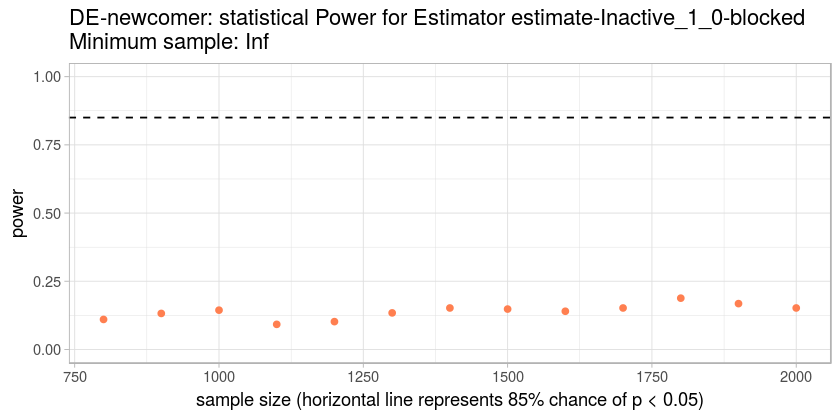

Saving 6.67 x 6.67 in image


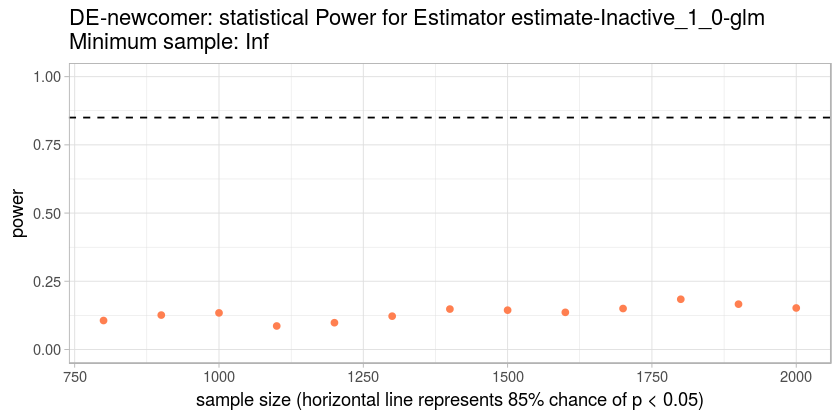

Saving 6.67 x 6.67 in image


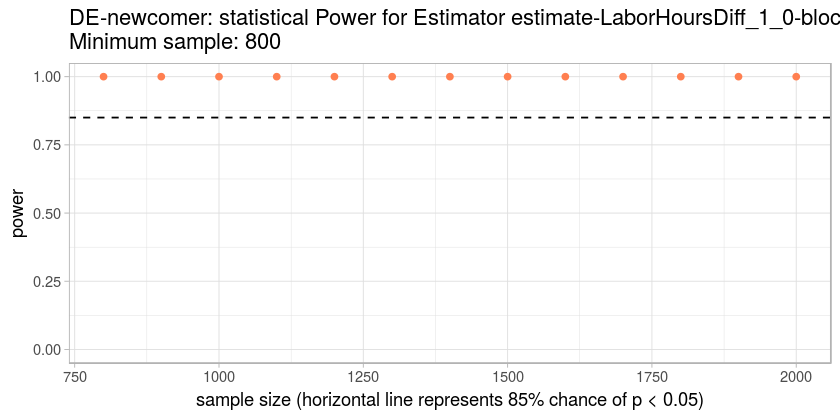

Saving 6.67 x 6.67 in image


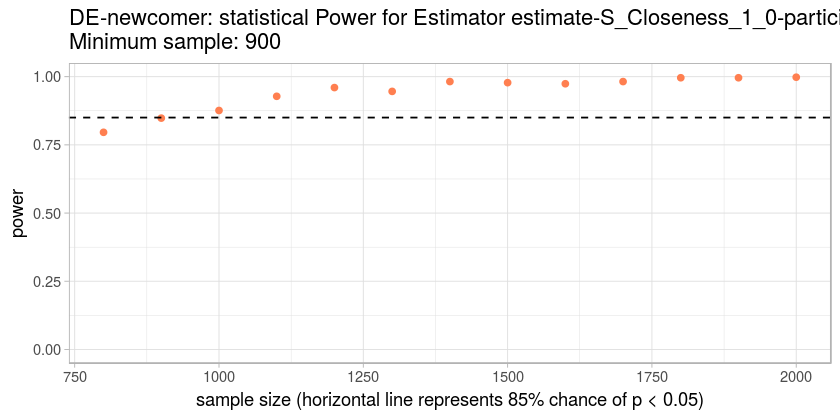

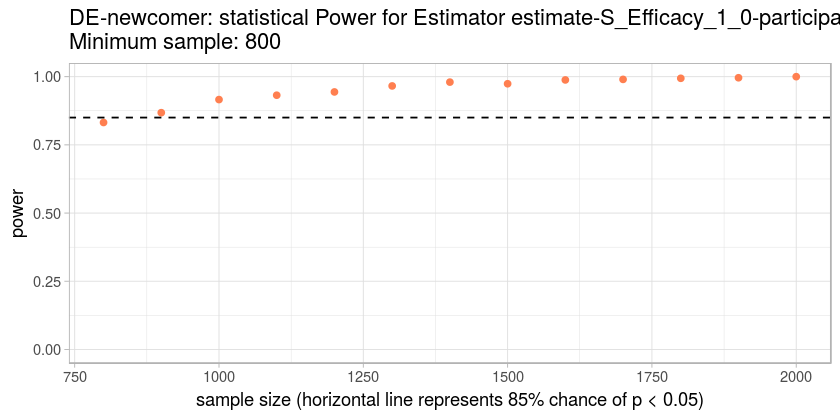

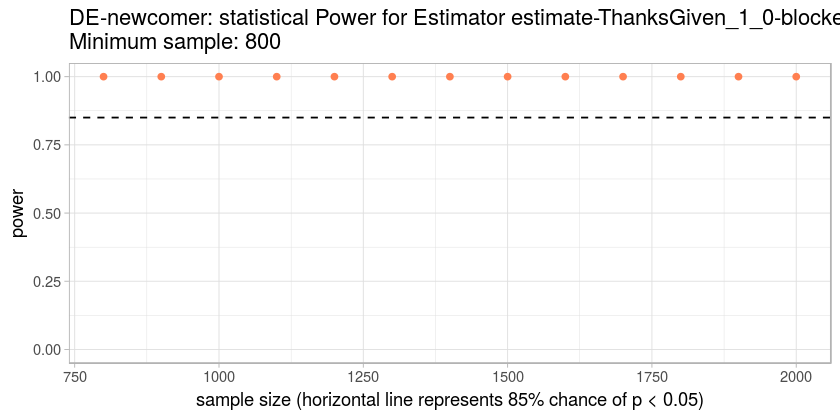

In [182]:
plot.power.results(de.newcomer.pa.results, pa.config.newcomer)

In [29]:
pa.config.experienced$pa.label <- "DE-experienced"
de.experienced.pa.results <- iterate.for.power(subset(de.power.sub.df, prev_experience!=0),
                                             pa.config.experienced, 
                                             survival.tables, "de",
                                             diagnose.experiment, 300)
beep(sound="treasure")

[1] "experience groups: 6 .min: 600 .max: 36000 .current n per experience group: 100 .current total n: 600"
[1] "     seconds: 123"
[1] "experience groups: 6 .min: 600 .max: 36000 .current n per experience group: 400 .current total n: 2400"
[1] "     seconds: 462"
[1] "experience groups: 6 .min: 600 .max: 36000 .current n per experience group: 700 .current total n: 4200"
[1] "     seconds: 805"
[1] "experience groups: 6 .min: 600 .max: 36000 .current n per experience group: 1000 .current total n: 6000"


In [5]:
plot.power.results(experienced.pa.results, pa.config.experienced)

ERROR: Error in plot.power.results(experienced.pa.results, pa.config.experienced): could not find function "plot.power.results"


### Persian Power Analysis

In [ ]:
fa.pa.config.newcomer$pa.label <- "FA-newcomer"
newcomer.pa.results <- iterate.for.power(subset(fa.power.sub.df, prev_experience==0),
                                         pa.config.newcomer, 
                                         survival.tables, "fa",
                                         diagnose.experiment, 50) 
beep(sound="treasure")